In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors
from netCDF4 import Dataset
import pandas as pd
import properscoring as ps
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import warnings
import xarray as xr
from matplotlib import cm
from utils.evaluation import plot_predictions,plot_anomaly,plot_histogram,calc_peak,calc_mean,segment_image,segment_diff
from utils.metrics import calculate_crps
from global_land_mask import globe
from scipy.interpolate import griddata
# from utils.metrics import calculate_fid
import xesmf as xe
warnings.filterwarnings("ignore")

sns.set_style("white")
sns.set_palette(sns.color_palette("Paired"))

In [2]:
mode = 'validation'
real = np.load('/user/home/al18709/work/cgan_predictions/%s_real-opt.npy' % mode)[0][:,:,:,0]
pred = np.load('/user/home/al18709/work/cgan_predictions/%s_pred-opt.npy' % mode)[0][:,:,:,0]
inputs = np.load('/user/home/al18709/work/cgan_predictions/%s_input-opt.npy' % mode)[0][:,:,:,0]
meta = pd.read_csv('/user/work/al18709/tc_data_mswep/valid_meta.csv')

In [3]:
print(real.shape)
print(meta.shape)

(3193, 100, 100)
(3098, 5)


In [112]:
# plot_anomaly(real[0],cmap='Blues',plot='show',vmin=0,vmax=20)
# plot_anomaly(pred[0],cmap='Blues',plot='show',vmin=0,vmax=20)

# i = 1
# centre_lat = meta['centre_lat'][i]
# centre_lon = meta['centre_lon'][i]

print(meta.shape)
nstorms,_ = meta.shape
landfall_sids = []
# get the landfalling storms
for i in range(nstorms):
	centre_lat = meta['centre_lat'][i]
	centre_lon = meta['centre_lon'][i]
	# print(centre_lon)
	if centre_lon > 180:
		centre_lon = centre_lon - 180
	landfall = globe.is_land(centre_lat, centre_lon)
	if landfall:
		sid = meta['sid'][i]
		# exec('if not sid_%s: sid_%s = []' % (sid,sid), globals())
		# # exec('sid_%s = []' % sid)
		# exec('sid_%s.append(i)' % sid)
		landfall_sids.append(sid)

# find indices of all landfalling snapshots
landfall_sids = list(dict.fromkeys(landfall_sids))
print(landfall_sids)

for sid in landfall_sids:
	indices = meta.sid[meta.sid == sid].index.tolist()
	# print(indices)
	exec('sid_%s = indices' % sid)

j = 713
sid = meta['sid'][j]
centre_lat = meta['centre_lat'][j]
centre_lon = meta['centre_lon'][j]
print(centre_lat,centre_lon)

fp = '/bp1store/geog-tropical/data/Obs/MSWEP/3hourly_invertlat/2000342.00.nc'
d = Dataset(fp, 'r')
lat = d.variables['lat'][:] #lat
lon = d.variables['lon'][:] #lon		

# clip to whole TC region
lat_lower_bounds = []
lat_upper_bounds = []
lon_lower_bounds = []
lon_upper_bounds = []

for i in sid_2008169N08135:
	lat_lower_bounds.append((np.abs(lat-meta['centre_lat'][i]+5.)).argmin())
	lat_upper_bounds.append((np.abs(lat-meta['centre_lat'][i]-5.)).argmin())
	lon_lower_bounds.append((np.abs(lon-meta['centre_lon'][i]+5.)).argmin())
	lon_upper_bounds.append((np.abs(lon-meta['centre_lon'][i]-5.)).argmin())

lat_lower_bound = min(lat_lower_bounds)
lat_upper_bound = max(lat_upper_bounds)
lon_lower_bound = min(lon_lower_bounds)
lon_upper_bound = max(lon_upper_bounds)

print(lat[lat_lower_bound])
print(lat[lat_upper_bound])
print(lon[lon_lower_bound])
print(lon[lon_upper_bound])

lats = lat[lat_lower_bound:lat_upper_bound]
# lats = np.flip(lats)
lons = lon[lon_lower_bound:lon_upper_bound]


grid_x, grid_y = np.meshgrid(lats, lons)
a = np.zeros((grid_x.shape))
print(a.shape)
accumulated_ds = xr.Dataset(
	    data_vars=dict(
	        precipitation=(["x", "y"], a)),
	    coords=dict(
	        lon=("x", lons),
	        lat=("y", lats),
	    ))
print('',grid_x.shape)

accumulated = np.zeros(grid_x.shape)
for i in sid_2008169N08135:
	lat_lower_bound = (np.abs(lat-meta['centre_lat'][i]+5.)).argmin()
	lat_upper_bound = (np.abs(lat-meta['centre_lat'][i]-5.)).argmin()
	lon_lower_bound = (np.abs(lon-meta['centre_lon'][i]+5.)).argmin()
	lon_upper_bound = (np.abs(lon-meta['centre_lon'][i]-5.)).argmin()
	storm_lats = lat[lat_lower_bound:lat_upper_bound]
	# storm_lats = np.flip(storm_lats)
	storm_lons = lon[lon_lower_bound:lon_upper_bound]
	points = [(x,y) for x in storm_lats for y in storm_lons]
	values = real[i].flatten()
	new_values = griddata(points, values, (grid_x, grid_y), method='nearest')

	ds = xr.Dataset(
	    data_vars=dict(
	        precipitation=(["x", "y"], real[i]),
	    ),
	    coords=dict(
	        lon=("x", storm_lons),
	        lat=("y", storm_lats),
	    ))
	regridder = xe.Regridder(ds, accumulated_ds, "nearest_s2d")
	ds_out = regridder(ds)
	accumulated_ds = accumulated_ds + ds_out
	# accumulated_ds = xr.combine_by_coords([accumulated_ds.expand_dims('trial'),ds.expand_dims('trial')])
	# print("accumulated")
	# accumulated = accumulated + new_values

print(accumulated_ds)
print(grid_x.shape)
print(grid_y.shape)
hr_ds = xr.Dataset(
	    data_vars=dict(
	        precipitation=(["x", "y"], real[i]),
	    ),
	    coords=dict(
	        lon=("x", storm_lons),
	        lat=("y", storm_lats),
	    ))


(3098, 5)
['2007254N18140', '2008241N19303', '2010236N12341', '2018250N12170', '2001248N23125', '2008203N18276', '2013306N07162', '2010285N13145', '2011038S11062', '2008169N08135', '2012331N03157', '2008262N16142', '2006081S14129', '2020211N13306', '2008037S10055', '2013220N12137', '2009346S10172', '2019243N06136', '2018044S10133', '2017242N16333', '2017097S12171', '2016248N15255', '2016253N13144', '2013360S12124', '2003235N20253', '2016185N08145', '2007274N18131', '2006228N10218', '2011233N15301', '2010293N17093', '2002268N15163', '2004263N13153', '2011270N18139', '2004072S11146', '2017228N14314', '2006114N08090', '2002033S13121']
16.775 120.625
5.749995
20.149998
115.750015
132.65001
(169, 144)
 (169, 144)
<xarray.Dataset>
Dimensions:        (x: 169, y: 144)
Coordinates:
    lon            (x) float32 115.8 115.9 115.9 116.1 ... 132.4 132.4 132.6
    lat            (y) float32 5.75 5.85 5.95 6.05 ... 19.75 19.85 19.95 20.05
Dimensions without coordinates: x, y
Data variables:
    pre

In [113]:
tcs = pd.read_csv('/user/work/al18709/ibtracks/tc_files.csv')
print(tcs['filepath_mswep'][0])

/bp1store/geog-tropical/data/Obs/MSWEP/3hourly_invertlat/2000342.00.nc


<xarray.Dataset>
Dimensions:        (x: 169, y: 144)
Coordinates:
    lon            (x) float32 115.8 115.9 115.9 116.1 ... 132.4 132.4 132.6
    lat            (y) float32 5.75 5.85 5.95 6.05 ... 19.75 19.85 19.95 20.05
Dimensions without coordinates: x, y
Data variables:
    precipitation  (x, y) float64 1.375 1.312 1.25 1.312 ... 17.44 17.38 17.38


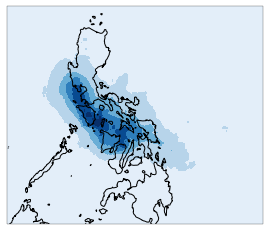

In [114]:
plot_accumulated(accumulated_ds['precipitation'],accumulated_ds['lat'].values,accumulated_ds['lon'].values,plot='show')

lat2d,lon2d = np.meshgrid(accumulated_ds['lat'].values,accumulated_ds['lon'].values)

fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
# fig, ax = plt.subplots()
# cmap = get_custom_color_palette()
cmap ='Blues'
# c = ax.contourf(lon2d,lat2d,data,60,vmin=-60,vmax=60,cmap = cmap, transform=ccrs.PlateCarree())

# c = ax.pcolor(accumulated_ds['precipitation'],vmin=0,vmax=20,cmap = cmap, transform=ccrs.PlateCarree())
c = ax.contourf(lon2d,lat2d,accumulated_ds['precipitation'],vmin=0,vmax=200,cmap = cmap, transform=ccrs.PlateCarree())
# c = xr.plot.pcolormesh(accumulated_ds['precipitation'],transform=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.outline_patch.set_linewidth(0.3)
# gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
#                   linewidth=2, color='gray', alpha=0.5, linestyle='--')
# cbar = plt.colorbar(c, shrink=0.54)
# cbar.outline.set_linewidth(0.5)
# cbar.ax.tick_params(labelsize=6,width=0.5)
# plt.title('Extreme')

print(accumulated_ds)
real_accumulated = accumulated_ds
plt.show()

(3098, 5)
['2007254N18140', '2008241N19303', '2010236N12341', '2018250N12170', '2001248N23125', '2008203N18276', '2013306N07162', '2010285N13145', '2011038S11062', '2008169N08135', '2012331N03157', '2008262N16142', '2006081S14129', '2020211N13306', '2008037S10055', '2013220N12137', '2009346S10172', '2019243N06136', '2018044S10133', '2017242N16333', '2017097S12171', '2016248N15255', '2016253N13144', '2013360S12124', '2003235N20253', '2016185N08145', '2007274N18131', '2006228N10218', '2011233N15301', '2010293N17093', '2002268N15163', '2004263N13153', '2011270N18139', '2004072S11146', '2017228N14314', '2006114N08090', '2002033S13121']
16.775 120.625
5.749995
20.149998
115.750015
132.65001
(169, 144)
 (169, 144)
<xarray.Dataset>
Dimensions:        (x: 169, y: 144)
Coordinates:
    lon            (x) float32 115.8 115.9 115.9 116.1 ... 132.4 132.4 132.6
    lat            (y) float32 5.75 5.85 5.95 6.05 ... 19.75 19.85 19.95 20.05
Dimensions without coordinates: x, y
Data variables:
    pre

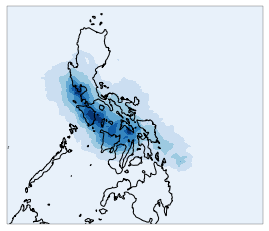

<xarray.Dataset>
Dimensions:        (x: 169, y: 144)
Coordinates:
    lon            (x) float32 115.8 115.9 115.9 116.1 ... 132.4 132.4 132.6
    lat            (y) float32 5.75 5.85 5.95 6.05 ... 19.75 19.85 19.95 20.05
Dimensions without coordinates: x, y
Data variables:
    precipitation  (x, y) float64 8.773 8.527 8.359 8.358 ... 8.518 8.881 8.881


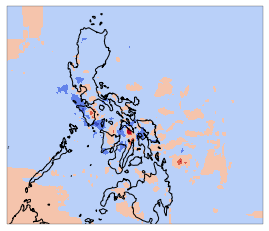

In [119]:
# https://earthobservatory.nasa.gov/images/8868/rainfall-from-typhoon-fengshen

# plot_anomaly(real[0],cmap='Blues',plot='show',vmin=0,vmax=20)
# plot_anomaly(pred[0],cmap='Blues',plot='show',vmin=0,vmax=20)

# i = 1
# centre_lat = meta['centre_lat'][i]
# centre_lon = meta['centre_lon'][i]

print(meta.shape)
nstorms,_ = meta.shape
landfall_sids = []
# get the landfalling storms
for i in range(nstorms):
	centre_lat = meta['centre_lat'][i]
	centre_lon = meta['centre_lon'][i]
	# print(centre_lon)
	if centre_lon > 180:
		centre_lon = centre_lon - 180
	landfall = globe.is_land(centre_lat, centre_lon)
	if landfall:
		sid = meta['sid'][i]
		# exec('if not sid_%s: sid_%s = []' % (sid,sid), globals())
		# # exec('sid_%s = []' % sid)
		# exec('sid_%s.append(i)' % sid)
		landfall_sids.append(sid)

# find indices of all landfalling snapshots
landfall_sids = list(dict.fromkeys(landfall_sids))
print(landfall_sids)

for sid in landfall_sids:
	indices = meta.sid[meta.sid == sid].index.tolist()
	# print(indices)
	exec('sid_%s = indices' % sid)

j = 713
sid = meta['sid'][j]
centre_lat = meta['centre_lat'][j]
centre_lon = meta['centre_lon'][j]
print(centre_lat,centre_lon)

fp = '/bp1store/geog-tropical/data/Obs/MSWEP/3hourly_invertlat/2000342.00.nc'
d = Dataset(fp, 'r')
lat = d.variables['lat'][:] #lat
lon = d.variables['lon'][:] #lon		

# clip to whole TC region
lat_lower_bounds = []
lat_upper_bounds = []
lon_lower_bounds = []
lon_upper_bounds = []

for i in sid_2008169N08135:
	lat_lower_bounds.append((np.abs(lat-meta['centre_lat'][i]+5.)).argmin())
	lat_upper_bounds.append((np.abs(lat-meta['centre_lat'][i]-5.)).argmin())
	lon_lower_bounds.append((np.abs(lon-meta['centre_lon'][i]+5.)).argmin())
	lon_upper_bounds.append((np.abs(lon-meta['centre_lon'][i]-5.)).argmin())

lat_lower_bound = min(lat_lower_bounds)
lat_upper_bound = max(lat_upper_bounds)
lon_lower_bound = min(lon_lower_bounds)
lon_upper_bound = max(lon_upper_bounds)

print(lat[lat_lower_bound])
print(lat[lat_upper_bound])
print(lon[lon_lower_bound])
print(lon[lon_upper_bound])

lats = lat[lat_lower_bound:lat_upper_bound]
# lats = np.flip(lats)
lons = lon[lon_lower_bound:lon_upper_bound]


grid_x, grid_y = np.meshgrid(lats, lons)
a = np.zeros((grid_x.shape))
print(a.shape)
accumulated_ds = xr.Dataset(
	    data_vars=dict(
	        precipitation=(["x", "y"], a)),
	    coords=dict(
	        lon=("x", lons),
	        lat=("y", lats),
	    ))
print('',grid_x.shape)

accumulated = np.zeros(grid_x.shape)
for i in sid_2008169N08135:
	lat_lower_bound = (np.abs(lat-meta['centre_lat'][i]+5.)).argmin()
	lat_upper_bound = (np.abs(lat-meta['centre_lat'][i]-5.)).argmin()
	lon_lower_bound = (np.abs(lon-meta['centre_lon'][i]+5.)).argmin()
	lon_upper_bound = (np.abs(lon-meta['centre_lon'][i]-5.)).argmin()
	storm_lats = lat[lat_lower_bound:lat_upper_bound]
	# storm_lats = np.flip(storm_lats)
	storm_lons = lon[lon_lower_bound:lon_upper_bound]
	# points = [(x,y) for x in storm_lats for y in storm_lons]
	# values = real[i].flatten()
	# new_values = griddata(points, values, (grid_x, grid_y), method='nearest')

	ds = xr.Dataset(
	    data_vars=dict(
	        precipitation=(["x", "y"], pred[i]),
	    ),
	    coords=dict(
	        lon=("x", storm_lons),
	        lat=("y", storm_lats),
	    ))
	regridder = xe.Regridder(ds, accumulated_ds, "nearest_s2d")
	ds_out = regridder(ds)
	accumulated_ds = accumulated_ds + ds_out
	# accumulated_ds = xr.combine_by_coords([accumulated_ds.expand_dims('trial'),ds.expand_dims('trial')])
	# print("accumulated")
	# accumulated = accumulated + new_values

print(accumulated_ds)
print(grid_x.shape)
print(grid_y.shape)


fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
# fig, ax = plt.subplots()
# cmap = get_custom_color_palette()
cmap ='Blues'
# c = ax.contourf(lon2d,lat2d,data,60,vmin=-60,vmax=60,cmap = cmap, transform=ccrs.PlateCarree())

# c = ax.pcolor(accumulated_ds['precipitation'],vmin=0,vmax=20,cmap = cmap, transform=ccrs.PlateCarree())
c = ax.contourf(lon2d,lat2d,accumulated_ds['precipitation'],vmin=0,vmax=200,cmap = cmap, transform=ccrs.PlateCarree())
# c = xr.plot.pcolormesh(accumulated_ds['precipitation'],transform=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.outline_patch.set_linewidth(0.3)
# gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
#                   linewidth=2, color='gray', alpha=0.5, linestyle='--')
# cbar = plt.colorbar(c, shrink=0.54)
# cbar.outline.set_linewidth(0.5)
# cbar.ax.tick_params(labelsize=6,width=0.5)
# plt.title('Extreme')

print(accumulated_ds)
pred_accumulated = accumulated_ds
plt.show()

a = pred_accumulated - real_accumulated

fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})

cmap ='coolwarm'
c = ax.contourf(lon2d,lat2d,a['precipitation'],vmin=-50,vmax=50,cmap = cmap, transform=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.outline_patch.set_linewidth(0.3)


print(accumulated_ds)
pred_accumulated = accumulated_ds
plt.show()

(3098, 5)
['2007254N18140', '2008241N19303', '2010236N12341', '2018250N12170', '2001248N23125', '2008203N18276', '2013306N07162', '2010285N13145', '2011038S11062', '2008169N08135', '2012331N03157', '2008262N16142', '2006081S14129', '2020211N13306', '2008037S10055', '2013220N12137', '2009346S10172', '2019243N06136', '2018044S10133', '2017242N16333', '2017097S12171', '2016248N15255', '2016253N13144', '2013360S12124', '2003235N20253', '2016185N08145', '2007274N18131', '2006228N10218', '2011233N15301', '2010293N17093', '2002268N15163', '2004263N13153', '2011270N18139', '2004072S11146', '2017228N14314', '2006114N08090', '2002033S13121']
16.775 120.625
5.749995
20.149998
115.750015
132.65001
(169, 144)
 (169, 144)
<xarray.Dataset>
Dimensions:        (x: 169, y: 144)
Coordinates:
    lon            (x) float32 115.8 115.9 115.9 116.1 ... 132.4 132.4 132.6
    lat            (y) float32 5.75 5.85 5.95 6.05 ... 19.75 19.85 19.95 20.05
Dimensions without coordinates: x, y
Data variables:
    pre

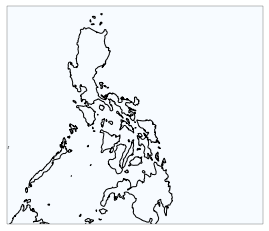

In [126]:
print(meta.shape)
nstorms,_ = meta.shape
landfall_sids = []
# get the landfalling storms
for i in range(nstorms):
	centre_lat = meta['centre_lat'][i]
	centre_lon = meta['centre_lon'][i]
	# print(centre_lon)
	if centre_lon > 180:
		centre_lon = centre_lon - 180
	landfall = globe.is_land(centre_lat, centre_lon)
	if landfall:
		sid = meta['sid'][i]
		# exec('if not sid_%s: sid_%s = []' % (sid,sid), globals())
		# # exec('sid_%s = []' % sid)
		# exec('sid_%s.append(i)' % sid)
		landfall_sids.append(sid)

# find indices of all landfalling snapshots
landfall_sids = list(dict.fromkeys(landfall_sids))
print(landfall_sids)

for sid in landfall_sids:
	indices = meta.sid[meta.sid == sid].index.tolist()
	# print(indices)
	exec('sid_%s = indices' % sid)

j = 713
sid = meta['sid'][j]
centre_lat = meta['centre_lat'][j]
centre_lon = meta['centre_lon'][j]
print(centre_lat,centre_lon)

fp = '/bp1store/geog-tropical/data/Obs/MSWEP/3hourly_invertlat/2000342.00.nc'
d = Dataset(fp, 'r')
lat = d.variables['lat'][:] #lat
lon = d.variables['lon'][:] #lon		

# clip to whole TC region
lat_lower_bounds = []
lat_upper_bounds = []
lon_lower_bounds = []
lon_upper_bounds = []

for i in sid_2008169N08135:
	lat_lower_bounds.append((np.abs(lat-meta['centre_lat'][i]+5.)).argmin())
	lat_upper_bounds.append((np.abs(lat-meta['centre_lat'][i]-5.)).argmin())
	lon_lower_bounds.append((np.abs(lon-meta['centre_lon'][i]+5.)).argmin())
	lon_upper_bounds.append((np.abs(lon-meta['centre_lon'][i]-5.)).argmin())

lat_lower_bound = min(lat_lower_bounds)
lat_upper_bound = max(lat_upper_bounds)
lon_lower_bound = min(lon_lower_bounds)
lon_upper_bound = max(lon_upper_bounds)

print(lat[lat_lower_bound])
print(lat[lat_upper_bound])
print(lon[lon_lower_bound])
print(lon[lon_upper_bound])

lats = lat[lat_lower_bound:lat_upper_bound]
# lats = np.flip(lats)
lons = lon[lon_lower_bound:lon_upper_bound]


grid_x, grid_y = np.meshgrid(lats, lons)
a = np.zeros((grid_x.shape))
print(a.shape)
accumulated_ds = xr.Dataset(
	    data_vars=dict(
	        precipitation=(["x", "y"], a)),
	    coords=dict(
	        lon=("x", lons),
	        lat=("y", lats),
	    ))
print('',grid_x.shape)

accumulated = np.zeros(grid_x.shape)
for i in sid_2008169N08135:
	lat_lr = np.arange(-89.5,90,1)
	lon_lr = np.arange(-179.5,180,1)
	lat_lower_bound = (np.abs(lat_lr-meta['centre_lat'][i]+5.)).argmin()
	lat_upper_bound = (np.abs(lat_lr-meta['centre_lat'][i]-5.)).argmin()
	lon_lower_bound = (np.abs(lon_lr-meta['centre_lon'][i]+5.)).argmin()
	lon_upper_bound = (np.abs(lon_lr-meta['centre_lon'][i]-5.)).argmin()
	storm_lats = lat[lat_lower_bound:lat_upper_bound]
	# storm_lats = np.flip(storm_lats)
	storm_lons = lon[lon_lower_bound:lon_upper_bound]
	# points = [(x,y) for x in storm_lats for y in storm_lons]
	# values = real[i].flatten()
	# new_values = griddata(points, values, (grid_x, grid_y), method='nearest')

	ds = xr.Dataset(
	    data_vars=dict(
	        precipitation=(["x", "y"], inputs[i]),
	    ),
	    coords=dict(
	        lon=("x", storm_lons),
	        lat=("y", storm_lats),
	    ))

	
	regridder = xe.Regridder(ds, accumulated_ds, "bilinear")
	ds_out = regridder(ds)
	# regridder = xe.Regridder(ds_out, accumulated_ds, "nearest_s2d")
	# ds_new = regridder(ds_out)
	accumulated_ds = accumulated_ds + ds_out
	# accumulated_ds = xr.combine_by_coords([accumulated_ds.expand_dims('trial'),ds.expand_dims('trial')])
	# print("accumulated")
	# accumulated = accumulated + new_values

print(accumulated_ds)
print(grid_x.shape)
print(grid_y.shape)


fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
# fig, ax = plt.subplots()
# cmap = get_custom_color_palette()
cmap ='Blues'
# c = ax.contourf(lon2d,lat2d,data,60,vmin=-60,vmax=60,cmap = cmap, transform=ccrs.PlateCarree())

# c = ax.pcolor(accumulated_ds['precipitation'],vmin=0,vmax=20,cmap = cmap, transform=ccrs.PlateCarree())
c = ax.contourf(lon2d,lat2d,accumulated_ds['precipitation'],vmin=0,vmax=200,cmap = cmap, transform=ccrs.PlateCarree())
# c = xr.plot.pcolormesh(accumulated_ds['precipitation'],transform=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.outline_patch.set_linewidth(0.3)
# gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
#                   linewidth=2, color='gray', alpha=0.5, linestyle='--')
# cbar = plt.colorbar(c, shrink=0.54)
# cbar.outline.set_linewidth(0.5)
# cbar.ax.tick_params(labelsize=6,width=0.5)
# plt.title('Extreme')

print(accumulated_ds)

plt.show()